COS30082 Applied Machine Learning - Assignment 1 - Bird Species Classification

Done by Leonardo Liew 102781996

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#### Configurations


# Update Config to point to your Google Drive
class Config:
    # Paths - UPDATED FOR GOOGLE DRIVE
    # Change "CUB200" to match YOUR folder name in Drive!
    TRAIN_DIR = '/content/drive/MyDrive/AML/Train'
    TEST_DIR = '/content/drive/MyDrive/AML/Test'
    TRAIN_LABELS = '/content/drive/MyDrive/AML/train.txt'
    TEST_LABELS = '/content/drive/MyDrive/AML/test.txt'

    # Model parameters
    NUM_CLASSES = 200
    IMG_SIZE = 224
    BATCH_SIZE = 32
    NUM_EPOCHS = 40

    # Training hyperparameters
    LEARNING_RATE = 0.0001
    WEIGHT_DECAY = 1e-4

    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Model choice
    MODEL_NAME = 'convnext_tiny'

config = Config()

# Verify paths exist
import os
print("✓ Checking paths...")
print(f"Train folder exists: {os.path.exists(config.TRAIN_DIR)}")
print(f"Test folder exists: {os.path.exists(config.TEST_DIR)}")
print(f"train.txt exists: {os.path.exists(config.TRAIN_LABELS)}")
print(f"test.txt exists: {os.path.exists(config.TEST_LABELS)}")


✓ Checking paths...
Train folder exists: True
Test folder exists: True
train.txt exists: True
test.txt exists: True


In [ ]:
#### Dataset class
class BirdDataset(Dataset):
    """Custom Dataset for CUB-200 birds"""

    def __init__(self, img_dir, label_file, transform=None):
        """
        Args:
            img_dir: Directory with all images
            label_file: Path to txt file with annotations
            transform: Optional transform to be applied on images
        """
        self.img_dir = img_dir
        self.transform = transform
        self.data = []

        # Read annotations
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 2:
                    img_name, label = parts[0], int(parts[1])
                    self.data.append((img_name, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
#### data augmentation and transformations

def get_transforms():
    """
    Returns train and test transforms
    Train: Heavy augmentation to prevent overfitting
    Test: Only resize and normalize (no augmentation!)
    """

    # Training transforms
    train_transform = transforms.Compose([

        ##### Light Augmentation ####
        # transforms.RandomResizedCrop(config.IMG_SIZE, scale=(0.9, 1.0)),
        # transforms.RandomHorizontalFlip(),
        # transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),

        ###### Medium augmentation #####
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop(config.IMG_SIZE, scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomGrayscale(p=0.1),
        transforms.Resize((256, 256)),

        #### HEAVY Augmentations #####
        #### these are too heavy maybe #####
        # transforms.Resize((256, 256)),
        # transforms.RandomResizedCrop(config.IMG_SIZE, scale=(0.8, 1.0)),
        # transforms.RandomHorizontalFlip(p=0.5),
        # transforms.RandomRotation(15), #
        # transforms.ColorJitter(brightness=0.2, contrast=0.2,
        #                       saturation=0.2, hue=0.1), #
        # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        # Optional: Add more augmentations
        # transforms.RandomGrayscale(p=0.1),


        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                           [0.229, 0.224, 0.225])  # ImageNet stats
    ])

    # Test transforms - NO AUGMENTATION (only preprocessing)
    test_transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                           [0.229, 0.224, 0.225])
    ])

    return train_transform, test_transform

In [ ]:
### model building
## the model building here is made so that a change of name
## is all that is required for the change of model.

def build_model(model_name='convnext_tiny', num_classes=200, pretrained=True):
    """
    Build transfer learning model

    Args:
        model_name: Name of pretrained model
        num_classes: Number of output classes
        pretrained: Whether to use pretrained weights

    Returns:
        model: PyTorch model
    """

    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        # Freeze all layers initially
        for param in model.parameters():
            param.requires_grad = False

        # Replace final layer with dropout
        num_features = model.fc.in_features


        # model.fc = nn.Sequential(
        #     nn.Dropout(0.5),  # Dropout for regularization
        #     nn.Linear(num_features, num_classes)
        # )

        model.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(num_features, 512),
          nn.BatchNorm1d(512),
          nn.ReLU(inplace=True),
          nn.Dropout(0.5),
          nn.Linear(512, num_classes)
        )

        # this freeze backbone initially
        # Freeze to train classifier head
        for param in model.parameters():
          param.requires_grad = False
        for param in model.fc.parameters():
          param.requires_grad = True


    elif model_name == 'convnext_tiny':
      model = models.convnext_tiny(pretrained=pretrained)

      # Freeze backbone
      for param in model.parameters():
          param.requires_grad = False

      # Replace the classifier head
      num_features = model.classifier[2].in_features
      model.classifier[2] = nn.Linear(num_features, num_classes)

      # Add dropout for regularization
      # model.classifier = nn.Sequential(
      #     nn.Flatten(),
      #     nn.Dropout(0.5),
      #     nn.Linear(num_features, num_classes)
      # )

      model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
      )

      # Unfreeze only the classifier first
      for param in model.classifier.parameters():
          param.requires_grad = True

    else:
        raise ValueError(f"Model {model_name} not supported")

    return model

In [ ]:
### training n validation functions
## this trains one epoch for the training loop

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        pbar.set_postfix({'loss': loss.item(),
                         'acc': 100. * correct / total})

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels)

def calculate_per_class_accuracy(predictions, labels, num_classes=200):
    """Calculate average accuracy per class"""
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)

    for pred, label in zip(predictions, labels):
        class_total[label] += 1
        if pred == label:
            class_correct[label] += 1

    # Avoid division by zero
    class_acc = np.divide(class_correct, class_total,
                          out=np.zeros_like(class_correct),
                          where=class_total!=0)

    avg_class_acc = np.mean(class_acc[class_total > 0])
    return avg_class_acc * 100

In [ ]:
## early stopping
# this is to stop if it is overfitting

class EarlyStopping:
    """Early stopping to prevent overfitting"""

    def __init__(self, patience=7, min_delta=0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.mode = mode

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif self._is_improvement(score):
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def _is_improvement(self, score):
        if self.mode == 'min':
            return score < self.best_score - self.min_delta
        else:  # mode == 'max'
            return score > self.best_score + self.min_delta

In [ ]:
### main training loop
## there are two phase to training loop
## first - frozen backbone
## second - unfreeze backbone

def main():
    print(f"Using device: {config.DEVICE}")
    print(f"Model: {config.MODEL_NAME}")

    # Get transforms
    train_transform, test_transform = get_transforms()

    # Create datasets
    train_dataset = BirdDataset(config.TRAIN_DIR, config.TRAIN_LABELS,
                                train_transform)
    test_dataset = BirdDataset(config.TEST_DIR, config.TEST_LABELS,
                               test_transform)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Testing samples: {len(test_dataset)}")

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE,
                            shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE,
                           shuffle=False, num_workers=2, pin_memory=True)

    # Build model
    model = build_model(config.MODEL_NAME, config.NUM_CLASSES)
    model = model.to(config.DEVICE)

    # Loss function with label smoothing (helps with overfitting)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Optimizer with weight decay (L2 regularization)
    optimizer = optim.Adam(model.parameters(),
                          lr=config.LEARNING_RATE,
                          weight_decay=config.WEIGHT_DECAY)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
    #                                                  factor=0.5, patience=3)

    # Early stopping
    early_stopping = EarlyStopping(patience=7, mode='min')

    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_avg_class_acc': []
    }

    best_val_acc = 0

    # PHASE 1: Train only classifier (frozen backbone)
    print("\n" + "="*60)
    print("PHASE 1: Training classifier only (frozen backbone)")
    print("="*60)

    for epoch in range(config.NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader,
                                                criterion, optimizer,
                                                config.DEVICE)

        # Validate (monitoring test set, NOT training on it)
        val_loss, val_acc, preds, labels = validate(model, test_loader,
                                                     criterion, config.DEVICE)

        # Calculate per-class accuracy
        avg_class_acc = calculate_per_class_accuracy(preds, labels)

        # Update scheduler
        scheduler.step(val_loss)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_avg_class_acc'].append(avg_class_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Val Avg Class Acc: {avg_class_acc:.2f}%")
        print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'avg_class_acc': avg_class_acc,
            }, 'best_model.pth')
            print(f"✓ Saved best model (Val Acc: {val_acc:.2f}%)")

        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("\n⚠ Early stopping triggered!")
            break


        # === Phase 2 trigger ===
        if epoch == 5:  # after 5 epochs of warmup
            print("🔓 Unfreezing entire model for fine-tuning...")
            for param in model.parameters():
                param.requires_grad = True
            # for param in model.layer1.parameters():
            #     param.requires_grad = False
            # for param in model.layer2.parameters():
            #     param.requires_grad = False


            optimizer = torch.optim.AdamW(model.parameters(),
                                          lr=config.LEARNING_RATE * 0.1,
                                          weight_decay=config.WEIGHT_DECAY * 10)
            #### Dont use this step thing cuz too abrupt
            # scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
            #                                             step_size=10,
            #                                             gamma=0.1)


            # optimizer = torch.optim.AdamW([
            #   # {'params': model.layer1.parameters(), 'lr': 1e-5},
            #   # {'params': model.layer2.parameters(), 'lr': 1e-5},
            #   {'params': model.layer3.parameters(), 'lr': 3e-5},
            #   {'params': model.layer4.parameters(), 'lr': 1e-5},
            #   {'params': model.fc.parameters(), 'lr': 1e-4},
            # ], weight_decay=5e-4)

            # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
              optimizer,
              mode='min',
              factor=0.5,
              patience=2
            )

    # OPTIONAL PHASE 2: Fine-tune last layers
    # Uncomment if you want to unfreeze and fine-tune
    """
    print("\n" + "="*60)
    print("PHASE 2: Fine-tuning last layers")
    print("="*60)

    # Unfreeze last layers
    for name, param in model.named_parameters():
        if "layer4" in name or "fc" in name:  # For ResNet
            param.requires_grad = True

    # Lower learning rate for fine-tuning
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                          lr=config.LEARNING_RATE * 0.1,
                          weight_decay=config.WEIGHT_DECAY)

    # Continue training...
    """

    print("\n" + "="*60)
    print("Training completed!")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    print("="*60)

    return model, history

In [ ]:
###visualisation
## this plots out the loss n accuracy graphs
def plot_training_history(history):
    """Plot training curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy
    axes[1].plot(history['train_acc'], label='Train Acc')
    axes[1].plot(history['val_acc'], label='Val Top-1 Acc')
    axes[1].plot(history['val_avg_class_acc'], label='Val Avg Class Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()


In [1]:
## this just runs everything

if __name__ == "__main__":
    model, history = main()
    plot_training_history(history)

NameError: name 'main' is not defined

In [ ]:
## copies the training history graph from runtime to drive folder

!cp /content/training_history.png /content/drive/MyDrive/AML

In [ ]:
## copies the model from runtime to drive folder

!cp /content/best_model.pth /content/drive/MyDrive/AML

Checkpoint training below

Resuming training from epoch 40, best val acc: 80.15%


Validation: 100%|██████████| 38/38 [00:10<00:00,  3.55it/s]


✓ Saved new best model (Val Acc: 80.32%)
Epoch [41]  Train Acc: 89.60%  Val Acc: 80.32%


Validation: 100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


Epoch [42]  Train Acc: 89.79%  Val Acc: 80.23%


Validation: 100%|██████████| 38/38 [00:10<00:00,  3.52it/s]


✓ Saved new best model (Val Acc: 80.48%)
Epoch [43]  Train Acc: 89.13%  Val Acc: 80.48%


Validation: 100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


Epoch [44]  Train Acc: 90.16%  Val Acc: 80.07%


Validation: 100%|██████████| 38/38 [00:10<00:00,  3.69it/s]


Epoch [45]  Train Acc: 90.68%  Val Acc: 80.23%


Validation: 100%|██████████| 38/38 [00:09<00:00,  3.89it/s]


Epoch [46]  Train Acc: 90.08%  Val Acc: 80.48%


Validation: 100%|██████████| 38/38 [00:10<00:00,  3.63it/s]


✓ Saved new best model (Val Acc: 80.56%)
Epoch [47]  Train Acc: 90.16%  Val Acc: 80.56%


Validation: 100%|██████████| 38/38 [00:10<00:00,  3.54it/s]


Epoch [48]  Train Acc: 90.02%  Val Acc: 80.56%


Validation: 100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


Epoch [49]  Train Acc: 89.98%  Val Acc: 80.56%


Validation: 100%|██████████| 38/38 [00:10<00:00,  3.55it/s]


✓ Saved new best model (Val Acc: 80.65%)
Epoch [50]  Train Acc: 90.45%  Val Acc: 80.65%


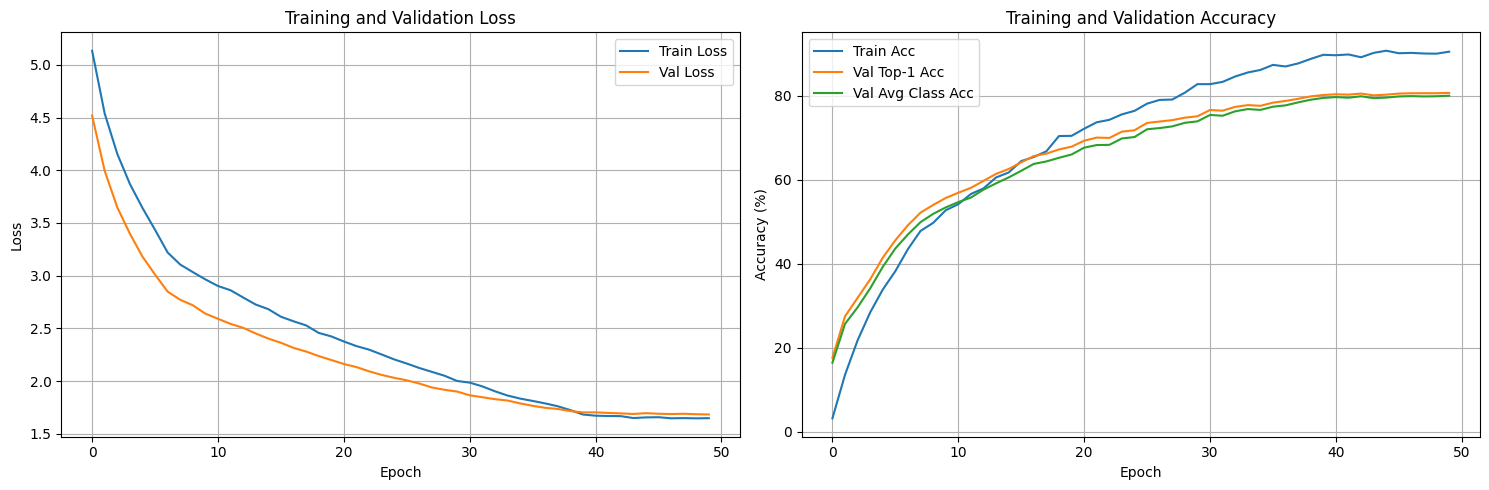

In [ ]:
## this is checkpoint training for the model
# because there wasnt enough free units on google colab for one whole training
# also because the accuracy graph looks like it can go higher
# as it has not plateaued

# === Load checkpoint ===
checkpoint = torch.load('/content/best_model.pth', map_location='cuda', weights_only=False)

optimizer = torch.optim.AdamW(model.parameters(),
                                          lr=config.LEARNING_RATE * 0.1,
                                          weight_decay=config.WEIGHT_DECAY * 10)
train_transform, test_transform = get_transforms()

train_dataset = BirdDataset(config.TRAIN_DIR, config.TRAIN_LABELS,
                                train_transform)
test_dataset = BirdDataset(config.TEST_DIR, config.TEST_LABELS,
                               test_transform)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE,
                            shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE,
                           shuffle=False, num_workers=2, pin_memory=True)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# restore model and optimizer states
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# continue from where you left off
start_epoch = checkpoint['epoch'] + 1
best_val_acc = checkpoint['val_acc']

print(f"Resuming training from epoch {start_epoch}, best val acc: {best_val_acc:.2f}%")

# === Optionally lower learning rate for fine-tuning ===
for g in optimizer.param_groups:
    g['lr'] *= 0.1  # reduce LR by 10x to fine-tune

# === Continue training ===
num_additional_epochs = 10  # or however many you want
for epoch in range(start_epoch, start_epoch + num_additional_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, config.DEVICE)
    val_loss, val_acc, preds, labels = validate(model, test_loader, criterion, config.DEVICE)
    avg_class_acc = calculate_per_class_accuracy(preds, labels)


    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_avg_class_acc'].append(avg_class_acc)

    # check if improved
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'avg_class_acc': avg_class_acc,
        }, 'best_model.pth')
        print(f"✓ Saved new best model (Val Acc: {val_acc:.2f}%)")

    print(f"Epoch [{epoch+1}]  Train Acc: {train_acc:.2f}%  Val Acc: {val_acc:.2f}%")

plot_training_history(history)

below is more visualisation

In [ ]:
## here are more visualisations done at the end
## this is to prep the visualisation variables for the function

import torch
import numpy as np
from tqdm import tqdm

def get_all_preds(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Collecting predictions"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

In [ ]:
preds, labels = get_all_preds(model, test_loader, config.DEVICE)


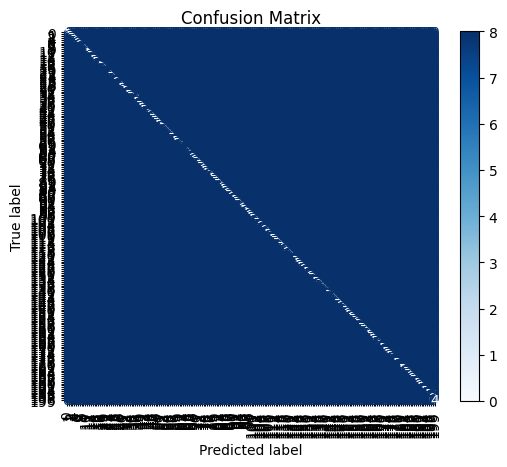

In [ ]:
## confusion matrix of all the classes
## but i dont think this will be included in report

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation='vertical', colorbar=True)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
## top 20 worst performing class

from sklearn.metrics import confusion_matrix

num_classes = config.NUM_CLASSES
cm = confusion_matrix(labels, preds)
class_acc = cm.diagonal() / cm.sum(axis=1)

# Handle any divisions by zero (if a class never appeared)
class_acc = np.nan_to_num(class_acc)

# Get indices of 20 worst-performing classes
worst_indices = np.argsort(class_acc)[:20]
print("🔍 20 Worst Classes:")
for idx in worst_indices:
    print(f"{idx}: {class_acc[idx]*100:.2f}% accuracy")



🔍 20 Worst Classes:
63: 0.00% accuracy
58: 0.00% accuracy
172: 16.67% accuracy
183: 16.67% accuracy
28: 20.00% accuracy
129: 25.00% accuracy
170: 25.00% accuracy
143: 28.57% accuracy
178: 33.33% accuracy
90: 33.33% accuracy
177: 40.00% accuracy
134: 40.00% accuracy
106: 40.00% accuracy
8: 40.00% accuracy
197: 40.00% accuracy
36: 42.86% accuracy
122: 42.86% accuracy
39: 50.00% accuracy
21: 50.00% accuracy
26: 50.00% accuracy


In [ ]:
## Load class names

import os

def get_class_names_from_txt(txt_path):
    class_names = {}
    with open(txt_path, 'r') as f:
        for line in f:
            img_path, label = line.strip().split()
            class_dir = os.path.dirname(img_path)
            class_name = class_dir.split('.')[-1]  # e.g., "Black_footed_Albatross"
            class_names[int(label)] = class_name
    # sort by label index
    return [class_names[i] for i in sorted(class_names.keys())]

# Example:
class_names = get_class_names_from_txt(config.TRAIN_LABELS)
print(f"Loaded {len(class_names)} class names")


Loaded 200 class names


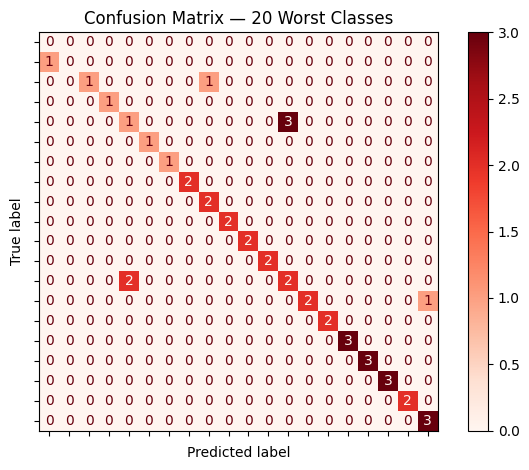

In [ ]:
## confusion matrix for top 20 worst performing classes

cm_worst = cm[np.ix_(worst_indices, worst_indices)]
worst_class_names = [class_names[i] for i in worst_indices]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_worst,
                              display_labels=worst_class_names)
disp.plot(cmap='Reds', xticks_rotation=45, colorbar=True)

plt.title("Confusion Matrix — 20 Worst Classes")
plt.tight_layout()
plt.savefig("worst_confusion_matrix.png", dpi=300)
plt.show()
